In [1]:
import numpy as np
from astropy.io import fits, ascii
import sys
from math import *
import matplotlib.pyplot as plt
# import ggraph as plot
from array import *
import icecream as ic
import pandas as pd

In [2]:
# some values

# constants. Planck 2018
pc = 3.0857e16 # parsec in m
Mpc = 3.0857e22 # Mpc to m
Msol = 2e30 # solar mass to kg
yr = 365*24*60*60 # yr to sec
nHz = 1e-9 # nHz to Hz
H0 = 67.66 * 1e3 / (Mpc)  # Hubble constant, km/sMpc^1
WM = 0.3111 # Omega matter
WL = 0.6889 # Omega lambda
G = 6.674e-11 # Newtonian constant
rho = 3 * H0**2 / (8 * np.pi * G) # closure density
c = 3e8 # speed of light

# mass of binary system, in solar mass
# system 1
m1 = 1e10
M1 = 2*m1 
Mc1 = 2**(-6/5)*(M1) # chirp mass, this only applies to equal mass
# system 2
m2 = 1e8
M2 = 2*m2 
Mc2 = 2**(-6/5)*(M2)

def chirpmass(Mc): 
    return Mc**(5/3)

# list of systems
Mlist = [M1, M1, M1, M1, M2]
Mclist = [chirpmass(Mc1), chirpmass(Mc1), chirpmass(Mc1), chirpmass(Mc1), chirpmass(Mc2)]

maxredshift = 1e5
zplot = np.linspace(0,maxredshift,1000)


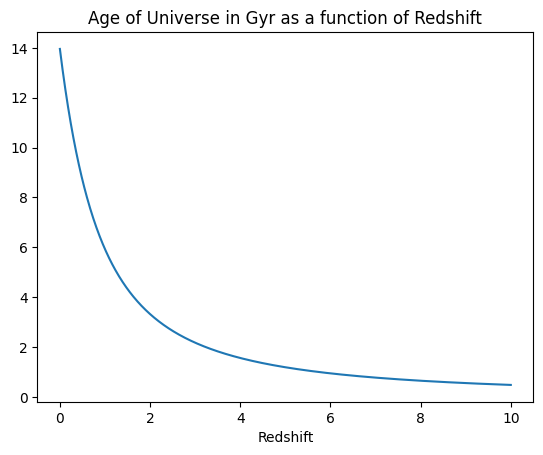

13.959818775536851 0.4795199309432874


In [3]:
# time plotted as an integral over redshift
def time(z):
    H0t = 66.88
    Htoyr = 977.8*1e9
    a = 1/(1+z)
    a2 = 1/(1+z)
    t_age = 0.5
    
    n = 1000
    for i in range(n):
        a = a2*(i+0.5)/n
        adot = np.sqrt(WM/a + WL*a*a )
        t_age = t_age + 1/adot

    z_age = a2*t_age/n # in units 1/H0
    z_age_yr = (Htoyr/H0t)*z_age # time in yr
    z_age_gyr = (Htoyr/H0t)*z_age/1e9
    
    return z_age_yr


#fig, ax = plot.figax(xlabel='redshift', ylabel='time in Gyr')
fig, ax = plt.subplots()
redten = np.linspace(0,10,1000)
ax.plot(redten,time(redten)/1e9)
ax.set_title("Age of Universe in Gyr as a function of Redshift")
ax.set_xlabel("Redshift")
plt.show()

#small test. age of universe is within planck
print(time(0)/1e9, time(10)/1e9)

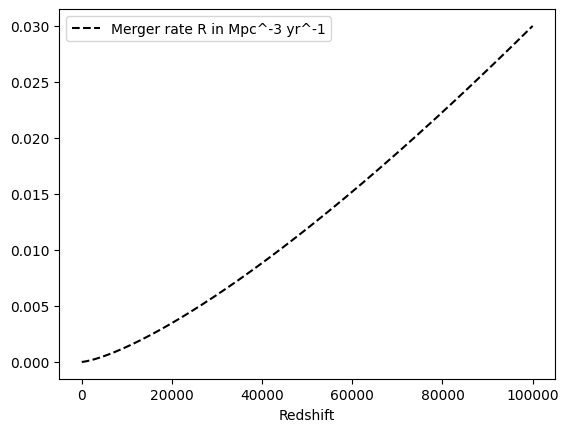

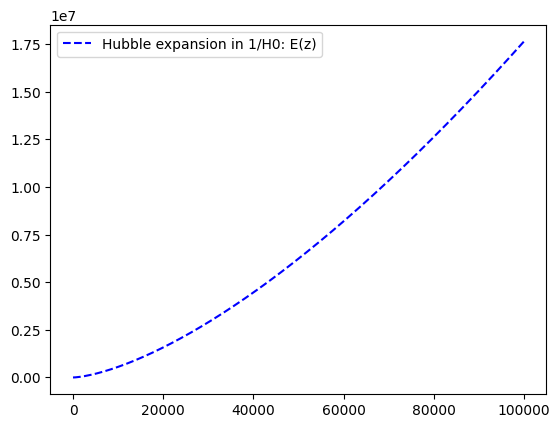

In [4]:
# merger rate
def R(z):
    R0 = 5.3/((1e3)**3) # in Mpc^-3  1/yr. turned Gpc^-3 to Mpc^-3. Will be normalized later
    return R0 * np.power(time(z)/time(0),-34/37)


# parameter set for Hubble expansion
def E(z):
    ainv = 1+z
    WK = 0
    E = WM*ainv**3 + WK*ainv**2 + WL
    E = np.sqrt(E)
    return E

plt.plot(zplot, R(zplot), 'k--',label="Merger rate R in Mpc^-3 yr^-1")
plt.xlabel("Redshift")
plt.legend()
plt.show()
plt.plot(zplot, E(zplot), 'b--', label="Hubble expansion in 1/H0: E(z)")
plt.legend()
plt.show()

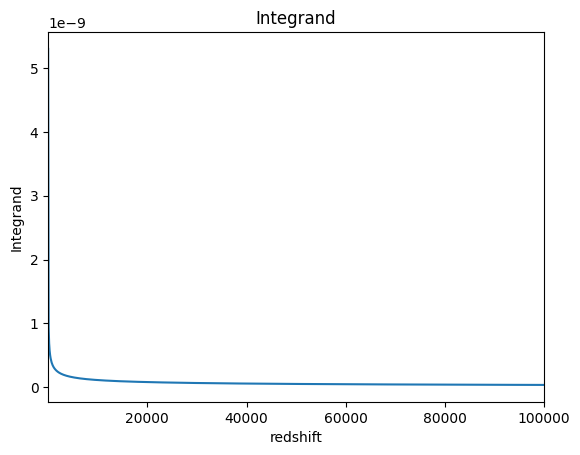

In [5]:
# Integration step one: Integrand
def integrand(z):
    numerator = R(z)
    denominator = (1+z)**(1/3) * E(z)
    return numerator / denominator


fig, ax = plt.subplots()
ax.set_xlabel('redshift') 
ax.set_ylabel('Integrand')
ax.plot(zplot,integrand(zplot))
ax.set_title("Integrand")
ax.set_xlim(1e-1,1e5)
plt.show()

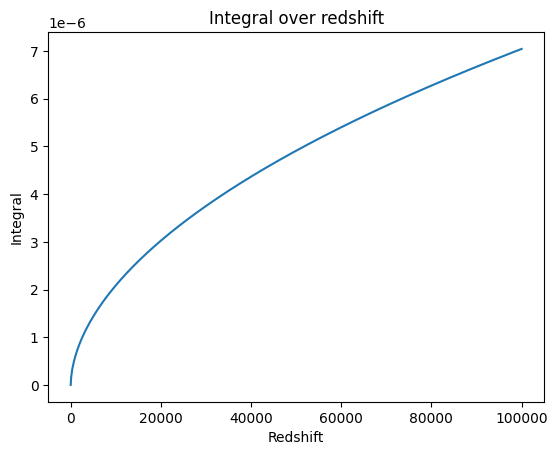

integral at redshift 0         0.0       
integral at redshift 10        3.6645974710146614e-08
integral at redshift 100       1.5939090223165177e-07
integral at redshift 1000      5.92995691847558e-07
integral at redshift 100000    7.045349573479871e-06


In [6]:
# Integration step 2: integration via midpoint. This cell takes a few seconds
def midpoint(a, b, n):
	# initialize result variable
	var = 0
	# calculate number of steps
	h = (b - a) / n
	# starting midpoint
	z = a + (h / 2)
	# evaluate function at subsequent midpoints
	for _ in range(n):
		var += integrand(z)
		z += h
	# multiply final result by step size
	return h * var

def integral(x):
    return midpoint(0,x,1000)


fig, ax = plt.subplots()
ax.plot(zplot,integral(zplot))
ax.set_title("Integral over redshift")
ax.set_xlabel("Redshift")
ax.set_ylabel("Integral")
plt.show()

zvalues = [0,10,100,1000,100000]
integralvalues = []
list_length = len(zvalues)

for i in range(list_length):
    print(f"{'integral at redshift ': <10}{zvalues[i] : <10}{integral(zvalues[i]): <10}")
    integralvalues.append(integral(zvalues[i]))

\begin{align}
 \Omega_{gw}(f) &= \frac{1}{\rho_c c^2 H_0}\int_0^{z_{max}}dz \left . \frac{R(z)f_r\frac{dE_{gw}}{df_r}}{(1+z)E(\Omega_r,\Omega_m,\Omega_\lambda,z)} \right\rvert_{f_r=(1+z)f} \\
 \Omega_{gw}(f) &= f^{2/3} {\color{red} \frac{\pi^{2/3}}{3 \rho_c H_0} \frac{(GM_c)^{5/3}}{G}  \int_0^{z_{max}}dz \frac{R(z)}{(1+z)^{1/3}E(\Omega_r,\Omega_m,\Omega_\lambda,z)} } \\
 \Omega_{gw} &= {\color{red}{A_{gw}}} \left( \frac{f}{f_{ref}} \right ) ^{2/3} \\
 \frac{dE_{gw}}{df_r} &= \frac{\pi (GM_c)^{5/3}}{3 G (\pi f_r)^{1/3}} \\
 \rho_c &= \frac{3H_0^2}{8\pi G}
\end{align}
In the code, the amplitude ${\color{red} A_{gw}}$ is divided into three parts: constants (G, $\pi$), the chirp-mass and the integral. 

In [7]:
# amplitude of strain at several redshifts
amplitude = []
rho_c = (3 * H0**2) / (8 * np.pi * G) # cosmological density
# constants = (8 * (G * np.pi)**(5/3)) / (9 * c**2 * H0**3) # explicit without rho_c, chirp mass is included in the amplitudefunction in its proper 5/3-powerlaw in first cell
constants = ((np.pi * G)**(2/3)) / (3 * rho_c * c**2 * H0) # with rho_c
normalizer = nHz**(2/3) * Msol**(5/3) * Mpc**(-3) * yr**(-1)


print(Mclist)

def amplitudefunction(redshiftentry, chirpmassentry):
    return constants * normalizer * Mclist[chirpmassentry] * integralvalues[redshiftentry]

for i in range(5):
    amplitude.append(amplitudefunction(i,i))

print(amplitude)

# frequency via broken power law
def bkn_pow(xvals, breaks, alphas):
    '''
    xvals: frequency range
    breaks: breaks between inspiral-merger(-ringdown)
    alphas: power-law of frequency
        a) energy density: 
            1 inspiral: alpha = 2/3
            2 merger: alpha = practically very low (cutoff at merger frequency)
        b) characteristic strain amplitude:
            1 inspiral: alpha = -2/3
            2 merger: alpha = cutoff
    '''
    try:
        if len(breaks) != len(alphas) - 1:
            raise ValueError("Dimensional mismatch. There should be more alpha than there are breaks")
    except TypeError:
        raise TypeError("Breaks and alphas should be array-like")
        if any(breaks < np.min(xvals)) or any(breaks > np.max(xvals)):
            raise ValueError("One or more break points fall outside given x bounds.")

    breakpoints = [np.min(xvals)] + breaks + [np.max(xvals)]
    chunks = [np.array([x for x in xvals if x >= breakpoints[i] and x <= breakpoints[i+1]]) for i in range(len(breakpoints)-1)]

    all_y = []

    #alpha = pd.cut(pd.Series(xvals),breakpoints,labels=alphas,include_lowest=True).to_numpy()

    for idx,xchunk in enumerate(chunks):
        yvals = xchunk**alphas[idx]
        all_y.append(yvals)
    
    for i in range(1,len(all_y)):
        all_y[i] *= np.abs(all_y[i-1][-1]/all_y[i][0]) 
    return(np.array([y for ychunk in all_y for y in ychunk])) 

def bkn_pow_smooth(x, A, x_b, a_1, a_2, delta=1):
    a_1 *= -1
    a_2 *= -1
    return A*(x/x_b)**(-a_1) * (0.5*(1+(x/x_b)**(1/delta)))**((a_1-a_2)*delta)



[3.684031498640393e+16, 3.684031498640393e+16, 3.684031498640393e+16, 3.684031498640393e+16, 17099759466766.994]
[0.0, 0.03206974039201467, 0.1394866665670308, 0.5189442508093198, 0.0028617940739773797]


In [21]:
# values entering the power law function
logfrequency = (-15,2) 
num_points = 200
x = np.logspace(*logfrequency,num_points)

def peakfrequency(redshift, totalmass):
    numerator = c**3 
    totalmasskg = totalmass * Msol 
    denominator = 12*np.sqrt(6) * np.pi * G * totalmasskg * (1 + redshift)
    return numerator / denominator

fpeak = []

for i in range(list_length):
    fpeak.append(peakfrequency(zvalues[i], Mlist[i]))

fp1 = fpeak[1]
fp2 = fpeak[2]
fp3 = fpeak[3]
fp4 = fpeak[4]

breaks1 = [fp1]
breaks2 = [fp2]
breaks3 = [fp3]
breaks4 = [fp4]
alphas = [2/3,-25]
alphash = [-2/3, -30]
Lo = -40


# omega_to_h_factor = (4 * G**(5/3)) / (3 * pi**(1/3) * H0)  
omega_to_h_factor = (8 * H0**2) / (2 * np.pi**2)

y1 = amplitude[1]* bkn_pow(x,breaks1,alphas)
# y1h = H0 * np.sqrt(3 * amplitude[1]* bkn_pow(x,breaks1,alphash) / (2 * np.pi)) 
y1h = np.sqrt(omega_to_h_factor * amplitude[1]) * bkn_pow(x,breaks1,alphash)
y2 = amplitude[2]* bkn_pow(x,breaks2,alphas)
# y2h = H0 * np.sqrt(3 * amplitude[2]* bkn_pow(x,breaks2,alphash) / (2 * np.pi)) 
y2h = np.sqrt(omega_to_h_factor * amplitude[2]) * bkn_pow(x,breaks2,alphash)
y3 = amplitude[3]* bkn_pow(x,breaks3,alphas)
# y3h = H0 * np.sqrt(3 * amplitude[3]* bkn_pow(x,breaks3,alphash) / (2 * np.pi))
y3h = np.sqrt(omega_to_h_factor * amplitude[3]) * bkn_pow(x,breaks3,alphash)
y4 = amplitude[4]* bkn_pow(x,breaks4,alphas)
# y4h = H0 * np.sqrt(3 * amplitude[4]* bkn_pow(x,breaks4,alphash) / (2 * np.pi))
y4h = np.sqrt(omega_to_h_factor * amplitude[4]) * bkn_pow(x,breaks4,alphash)

print(fpeak)

[1.0952438584905177e-07, 9.956762349913797e-09, 1.0843998598916018e-09, 1.094149708781736e-10, 1.0952329061614562e-10]


Spectrum-to-charstrain conversion
\begin{align}
    $
    \rho_c c^2 \Omega_{gw} &= \frac{\pi c^2}{4 G} f^2 h^2_c
    $
\end{align}

In [13]:
# Gabriella Agazie et al 2023 ApJL 951 L10 (DOI 10.3847/2041-8213/acda88)
df = pd.read_table(
    'sensitivity_curves/sensitivity_curves_NG15yr_fullPTA.txt',
    sep=','
)
df.columns = ['frequency','strain','signal','density']
df = df.set_index('frequency')

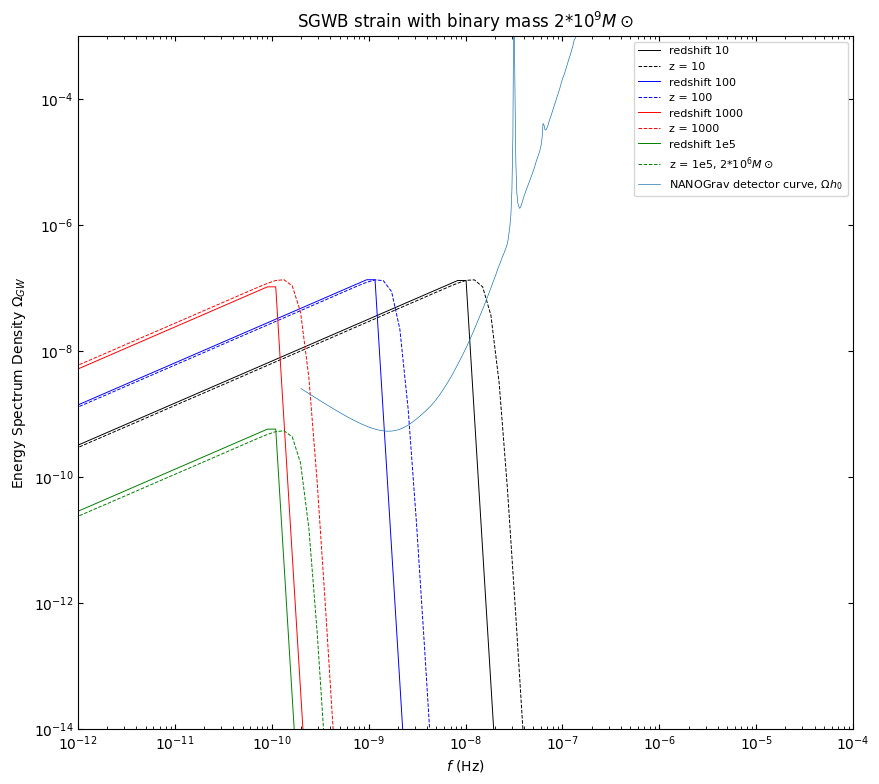

In [17]:
# plotting the power law function

plt.loglog(x,y1,'k-',label="redshift 10", linewidth=.7)
plt.loglog(x,bkn_pow_smooth(x,1.5e-8,fpeak[1]*2,2/3,-25,delta=0.15),'k--',label="z = 10", linewidth=.7)
plt.loglog(x,y2,'b-',label="redshift 100", linewidth=.7)
plt.loglog(x,bkn_pow_smooth(x,1.5e-8,fpeak[2]*2,2/3,-25,delta=0.15),'b--',label="z = 100", linewidth=.7)
plt.loglog(x,y3,'r-',label="redshift 1000", linewidth=.7)
plt.loglog(x,bkn_pow_smooth(x,1.5e-8,fpeak[3]*2,2/3,-25,delta=0.15),'r--',label="z = 1000", linewidth=.7)
plt.loglog(x,y4,'g-',label="redshift 1e5", linewidth=.7)
plt.loglog(x,bkn_pow_smooth(x,6e-11,fpeak[4]*2,2/3,-25,delta=0.15),'g--',label=f"z = 1e5, 2$*10^6M\\odot$", linewidth=.7)

plt.loglog(df.index, df['density'], linewidth=.5, label=f'NANOGrav detector curve, $\\Omega h_{{0}}$') # sensitivity curve


# for br in breaks1:
#     plt.axvline(br,linestyle="--",lw=1,color='k', linewidth=.7)
# for br in breaks2:
#     plt.axvline(br,linestyle="--",lw=1,color='b', linewidth=.7)
# for br in breaks3:
#     plt.axvline(br,linestyle="--",lw=1,color='r', linewidth=.7)
# for br in breaks4:
#     plt.axvline(br,linestyle="--",lw=1,color='g', linewidth=.7)

plt.legend(loc='upper right', fontsize=8)
plt.gca().tick_params(axis='both',which='both',direction='in',top=True,right=True)
plt.rcParams["figure.figsize"] = (10,9)
plt.xlabel(r"$f$ (Hz)")
plt.ylabel(r"Energy Spectrum Density $\Omega_{GW}$")
plt.title(f"SGWB strain with binary mass 2$*10^9M\\odot$")
plt.ylim(1e-14, 1e-3)
plt.xlim(1e-12,1e-4)
# plt.savefig('spectrum.pdf')
plt.show()

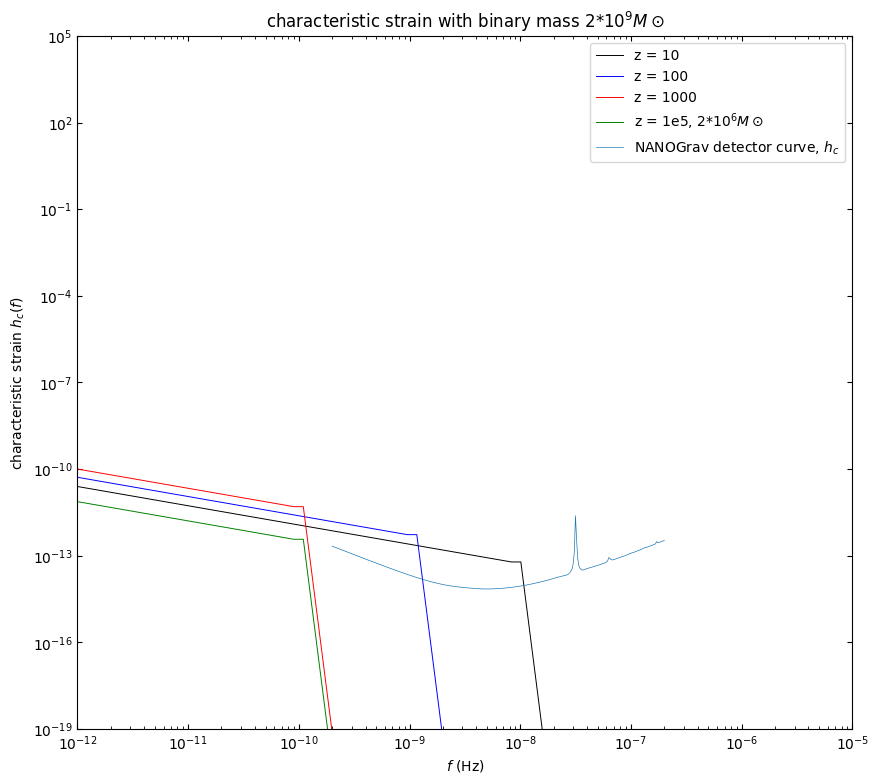

In [22]:
plt.loglog(x,y1h,'k-',label="z = 10", linewidth=.7)
plt.loglog(x,y2h,'b-',label="z = 100", linewidth=.7)
plt.loglog(x,y3h,'r-',label="z = 1000", linewidth=.7)
plt.loglog(x,y4h,'g-',label=f"z = 1e5, 2$*10^6M\\odot$", linewidth=.7)
# plt.loglog(x,bkn_pow_smooth(x,1e-17,fpeak[1],-2/3,-25,delta=0.15),label="Smoothly broken")

# for br in breaks1:
#     plt.axvline(br,linestyle="--",lw=1,color='k', linewidth=.7)
# for br in breaks2:
#     plt.axvline(br,linestyle="--",lw=1,color='b', linewidth=.7)
# for br in breaks3:
#     plt.axvline(br,linestyle="--",lw=1,color='r', linewidth=.7)
# for br in breaks4:
#     plt.axvline(br,linestyle="--",lw=1,color='g', linewidth=.7)

plt.loglog(df.index, df['strain'], linewidth=.5, label=f'NANOGrav detector curve, $h_{{c}}$') # sensitivity curve

plt.legend()
plt.gca().tick_params(axis='both',which='both',direction='in',top=True,right=True)
plt.rcParams["figure.figsize"] = (10,9)
plt.xlabel(r"$f$ (Hz)")
plt.ylabel(r"characteristic strain $h_{c}(f)$")
plt.title(f"characteristic strain with binary mass 2$*10^9M\\odot$")
plt.ylim(1e-19, 1e5)
plt.xlim(1e-12,1e-5)
# plt.savefig('charstrain.pdf')
plt.show()